In [1]:
import numpy as np
import cvxpy as cp
import pickle
import matplotlib.pyplot as plt
import fdt_verification
from fdt_verification import *
from fdt_verification_z3 import *
from util import *

### Settings
- using more than the number of available cores will interfere with experiment timing
- timeout is in seconds for a single minimum adversarial perturbation or global robustness test

In [2]:
# using more workers than can be run concurrently will interfere with experiment timing
n_workers = 20
# timeout in seconds for single minimum adversrial perturbation or global robustness test
timeout = 3600
# shorter timeout for the toy dataset comparison with Z3
timeout_toy = 300
# tolerance for minimum adversarial perturbation tests
tol = 1e-3

In [3]:
# list of dataset names from OpenML
dataset_names = ["banknote-authentication", "shuttle", "MagicTelescope", \
                "JapaneseVowels", "wall-robot-navigation", "helena", "satimage", \
                 "texture", "hill-valley", "sylva_agnostic"]

### Check solvers and choose one

In [4]:
print(cp.installed_solvers())
fdt_verification.solver = cp.ECOS

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCS']


# Comparison to Z3

In [ ]:
f = load_model("moons-linear-split")
x, y = load_robustness_test_points("moons1000")
perturbation, dist, exact, times = minimum_adversarial_perturbation_z3(f, x, tol, n_workers=n_workers, timeout=timeout_toy)
pickle.dump((perturbation, dist, exact, times), open("results/map_moons_z3.pkl", "wb"))
perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, tol, n_workers=n_workers, timeout=timeout_toy)
pickle.dump((perturbation, dist, exact, times), open("results/map_moons.pkl", "wb"))

In [5]:
perturbation, dist, exact, times = pickle.load(open("results/map_moons_z3.pkl", "rb"))
myperturbation, mydist, myexact, mytimes = pickle.load(open("results/map_moons.pkl", "rb"))
# sometimes the actual time taken is a little higher than the timeout
# we don't want to overcount those cases in the results
exact[times > timeout_toy] = False
times[times > timeout_toy] = timeout_toy
myexact[mytimes > timeout_toy] = False
mytimes[mytimes > timeout_toy] = timeout_toy

In [6]:
# check how many of the 1000 points have a result within tolerance
# ours should only be outside tolerance if it times out or the solver fails
sum(exact), sum(myexact)

(954, 1000)

In [7]:
# how many cases timed out
sum(times == timeout_toy), sum(mytimes == timeout_toy)

(46, 0)

In [8]:
# distribution of z3 times
np.mean(times), np.std(times), np.quantile(times, [0, 0.25, 0.5, 0.75, 1])

(18.739948163032533,
 62.2271082291507,
 array([  0.55059671,   1.23470527,   2.27897656,   5.07770121,
        300.        ]))

In [9]:
# distribution of our times
np.mean(mytimes), np.std(mytimes), np.quantile(mytimes, [0, 0.25, 0.5, 0.75, 1])

(3.1257268953323365,
 2.5438731897611224,
 array([ 0.46915054,  1.4485808 ,  2.21546948,  3.87612015, 11.97854567]))

# Minimum adversarial perturbations on OpenML datasets

In [10]:
# switch to Gurobi since it is more robust on the harder datasets
fdt_verification.solver = cp.GUROBI
# load the license so we don't get spammed with the notification in spawned processes
prob = cp.Problem(cp.Maximize(cp.Variable()), [])
prob.solve(solver=fdt_verification.solver)

Restricted license - for non-production use only - expires 2022-01-13


inf

In [ ]:
for name in dataset_names:
    f = load_model(name)
    x, y = load_robustness_test_points(name)
    perturbation, dist, exact, times = minimum_adversarial_perturbation(f, x, tol, n_workers=n_workers, timeout=timeout)
    pickle.dump((perturbation, dist, exact, times), open("results/map_" + name + ".pkl", "wb"))
    print(name)

banknote-authentication
100 100
20.714769990444182 21.217445057533634
['1.26', '8.94', '14.03', '25.34', '154.74']

shuttle
100 100
4.647094812393188 2.2566391480846493
['1.88', '3.20', '4.09', '5.68', '17.49']

MagicTelescope
98 98
256.3358147883415 573.5990775710177
['1.79', '25.83', '54.30', '221.65', '3600.00']

JapaneseVowels
100 100
186.28002146959304 461.08927705158857
['7.18', '18.23', '33.87', '106.38', '2773.63']

wall-robot-navigation
100 100
12.39833481311798 16.484363684574355
['0.55', '4.28', '8.20', '12.31', '129.75']

helena
100 100
112.59071455955505 92.75553412260393
['4.90', '66.48', '90.08', '134.73', '834.66']

satimage
96 96
224.07645862817765 698.4805392977921
['3.07', '16.36', '31.72', '144.46', '3600.00']

texture
98 98
385.24353286266324 644.4163219272444
['3.79', '84.04', '163.96', '361.53', '3600.00']

hill-valley
98 98
175.0446508193016 534.0234007508448
['2.17', '33.27', '46.64', '86.22', '3600.00']

sylva_agnostic
97 97
256.7604673576355 633.2768699801135

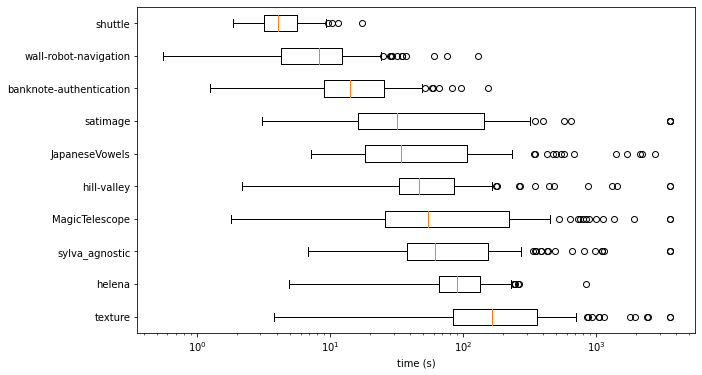

In [11]:
timeses = []
for name in dataset_names:
    perturbation, dist, exact, times = pickle.load(open("results/map_" + name + ".pkl", "rb"))
    exact[times > timeout] = False
    times[times > timeout] = timeout
    timeses.append(times)
    print(name)
    print(np.sum(exact), np.sum(times < timeout))
    print(np.mean(times), np.std(times))
    print(["%.2f"%t for t in np.quantile(times, [0, 0.25, 0.5, 0.75, 1])])
    print("")
plt.figure(figsize=(10,6))
order = np.argsort([-np.quantile(timeses, [0.5], axis=1)]).flatten()
plt.boxplot(np.array(timeses)[order].T, vert=False)
plt.yticks(np.arange(len(dataset_names))+1, labels=np.array(dataset_names)[order])
plt.xlabel("time (s)")
plt.xscale("log")
plt.show()

In [12]:
for name in dataset_names:
    f = load_model(name)
    print(name, f.size())

banknote-authentication (7, 39)
shuttle (5, 13)
MagicTelescope (8, 57)
JapaneseVowels (13, 251)
wall-robot-navigation (9, 33)
helena (8, 49)
satimage (12, 107)
texture (15, 163)
hill-valley (60, 305)
sylva_agnostic (8, 25)


# Global Robustness

In [ ]:
delta = [1e-3, 1e-2, 1e-1, 1e0]
epsilon = [0.2, 0.4, 0.6, 0.8]
for name in dataset_names:
    f = load_model(name)
    results = global_robustness(f, delta, epsilon, timeout=timeout)
    pickle.dump(results, open("results/gab_" + name + ".pkl", "wb"))
    print(name)

In [13]:
for name in dataset_names:
    results = pickle.load(open("results/gab_" + name + ".pkl", "rb"))
    print(name)
    for result in results:
        print(result[:3], "%.0f"%result[-1])
    print("")

banknote-authentication
(0.001, 0.2, None) 3603
(0.001, 0.4, True) 1023
(0.001, 0.6, True) 202
(0.001, 0.8, True) 57
(0.01, 0.2, None) 3603
(0.01, 0.4, True) 1253
(0.01, 0.6, True) 229
(0.01, 0.8, True) 57
(0.1, 0.2, None) 3602
(0.1, 0.4, None) 3603
(0.1, 0.6, True) 1718
(0.1, 0.8, True) 156
(1.0, 0.2, False) 12
(1.0, 0.4, False) 12
(1.0, 0.6, False) 12
(1.0, 0.8, False) 40

shuttle
(0.001, 0.2, True) 1858
(0.001, 0.4, True) 50
(0.001, 0.6, True) 10
(0.001, 0.8, True) 5
(0.01, 0.2, False) 12
(0.01, 0.4, False) 170
(0.01, 0.6, True) 174
(0.01, 0.8, True) 13
(0.1, 0.2, False) 4
(0.1, 0.4, False) 4
(0.1, 0.6, False) 6
(0.1, 0.8, False) 10
(1.0, 0.2, False) 5
(1.0, 0.4, False) 7
(1.0, 0.6, False) 14
(1.0, 0.8, False) 24

MagicTelescope
(0.001, 0.2, None) 3601
(0.001, 0.4, None) 3601
(0.001, 0.6, True) 3055
(0.001, 0.8, True) 22
(0.01, 0.2, None) 3602
(0.01, 0.4, None) 3601
(0.01, 0.6, None) 6280
(0.01, 0.8, True) 26
(0.1, 0.2, None) 3602
(0.1, 0.4, None) 3602
(0.1, 0.6, None) 3602
(0.1, 0.